In [1]:
from utils import plot_history, plot_result, calc_mean_image_metrics, predict_all, cut_build
from losses import ssim_l2

In [2]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Add, Subtract
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
images_clear_tt = np.load('images_clear_tt.npy')
images_noised_tt = np.load('images_noised_real_05_tt.npy')
images_clear_tt = images_clear_tt[:2500]
images_noised_tt = images_noised_tt[:2500]

In [4]:
#images_noised_train, images_noised_test, images_clear_train, images_clear_test = train_test_split(images_noised_tt,
#                                                                                                 images_clear_tt,
#                                                                                                 test_size=0.2,
#                                                                                                 random_state=42)

In [3]:
def dncnn_res(img_shape):

    input = Input(img_shape)
    n_blocks = 16
    x = Conv2D(128, kernel_size=(3,3),  #bias_initializer='glorot_normal',
                                        #kernel_initializer='glorot_normal',
                                        padding='same')(input)
    x = Activation('gelu')(x)
    for i in range(n_blocks):
        xx = Conv2D(128, kernel_size=(3,3),  #bias_initializer='glorot_normal', 
                                             #kernel_initializer='glorot_normal',
                                             padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = Activation('gelu')(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3),  #bias_initializer='glorot_normal', 
                                      #kernel_initializer='glorot_normal',
                                      padding='same')(x)
    out = Subtract()([input, x])

    model = Model(input, out)
    model.summary()
    
    return model

In [6]:
model = dncnn_res((256,256,3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5)

model.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = model.fit(images_noised_tt, images_clear_tt,
                    epochs=40,
                    callbacks=[reduce_lr],
                    validation_split=0.2,
                    #validation_data=(images_noised_test, images_clear_test),
                    batch_size=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 activation (Activation)        (None, 256, 256, 12  0           ['conv2d[0][0]']                 
                                8)                                                            

                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 256, 12  147584      ['add_5[0][0]']                  
                                8)                                                                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 256, 256, 12  512        ['conv2d_7[0][0]']               
 rmalization)                   8)                                                                
                                                                                                  
 activation_7 (Activation)      (None, 256, 256, 12  0           ['batch_normalization_6[0][0]']  
                                8)                                                                
                                                                                                  
 add_6 (Ad

                                8)                                'activation_13[0][0]']          
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 12  147584      ['add_12[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 256, 256, 12  512        ['conv2d_14[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 activation_14 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_13[0][0]'] 
                                8)                                                                
          

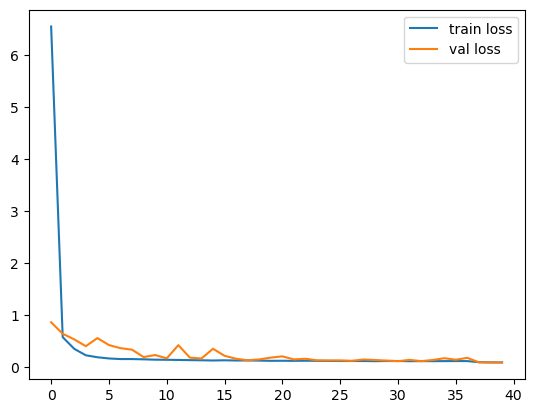

In [7]:
plot_history(history)

In [8]:
images_clear_val = np.load('images_clear_val.npy')
images_noised_val = np.load('images_noised_real_05_val.npy')
y = predict_all(model, images_noised_val)

1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 56ms/step


mean PSNR=30.664871215820312
mean SSIM=0.9149695634841919


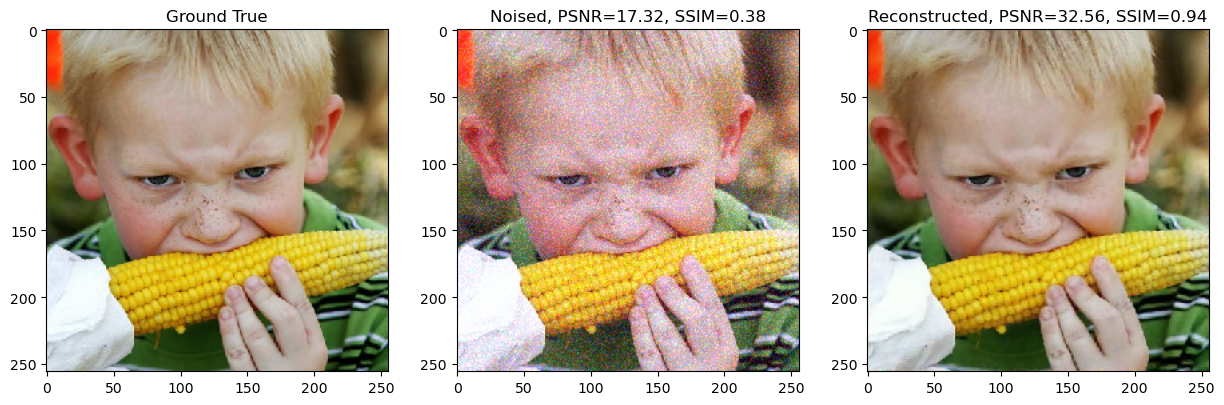

In [29]:
n=411
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear_val, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear_val[n],
            images_noised_val[n],
            y[n],
            max_value=max_value
           )

In [39]:
y_tt = predict_all(model, images_noised_tt)

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step


mean PSNR=30.7885684967041
mean SSIM=0.9170100688934326


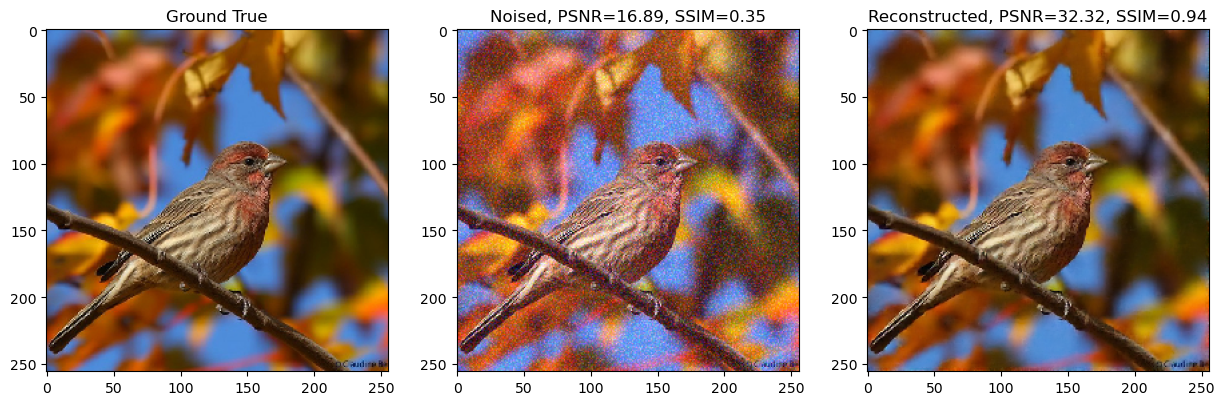

In [41]:
n=335
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear_tt, y_tt, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear_tt[n],
            images_noised_tt[n],
            y_tt[n],
            max_value=max_value
           )

In [ ]:
#model = dncnn_res((256,256,3))
#model.save('saved/dncnn_res/dncnn_res.h5', save_format='h5')

In [18]:
model.save('saved/final/dncnn_res_real_noise_0.50')
model.save_weights('saved/final/weights/dncnn_res_real_noise_0.50')

INFO:tensorflow:Assets written to: saved/final/dncnn_res_real_noise_0.50\assets


INFO:tensorflow:Assets written to: saved/final/dncnn_res_real_noise_0.50\assets


# check on real noised image

In [4]:
model = dncnn_res((256,256,3))
model.load_weights('saved/final/weights/dncnn_res_real_noise_0.50')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 activation (Activation)        (None, 256, 256, 12  0           ['conv2d[0][0]']                 
                                8)                                                            

                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 256, 12  147584      ['add_5[0][0]']                  
                                8)                                                                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 256, 256, 12  512        ['conv2d_7[0][0]']               
 rmalization)                   8)                                                                
                                                                                                  
 activation_7 (Activation)      (None, 256, 256, 12  0           ['batch_normalization_6[0][0]']  
                                8)                                                                
                                                                                                  
 add_6 (Ad

                                8)                                'activation_13[0][0]']          
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 12  147584      ['add_12[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 256, 256, 12  512        ['conv2d_14[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 activation_14 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_13[0][0]'] 
                                8)                                                                
          

In [12]:
images_real = np.load('images_real.npy')

14/14 [==============================] - 25s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed')

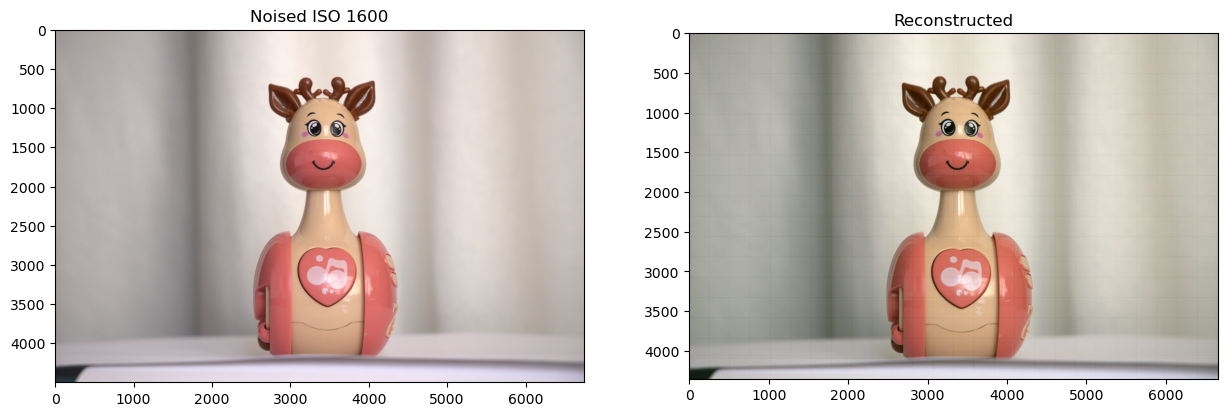

In [14]:
n=3
check_img = images_real[n]

cut_builds = cut_build(source_image=check_img)
images_real_patches = (cut_builds.cut()).astype('float32')
images_real_patches /= 255.
to_model = np.array(images_real_patches)
y_real = model.predict(to_model)
image_real_reconstructed = cut_builds.buid(y_real)

tf.keras.utils.save_img('image_reconstructed_1600.jpg', image_real_reconstructed)

plt.subplots(1,2, figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(check_img)
plt.title('Noised ISO 1600')
plt.subplot(1,2,2)
plt.imshow(image_real_reconstructed)
plt.title('Reconstructed')

14/14 [==============================] - 25s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed')

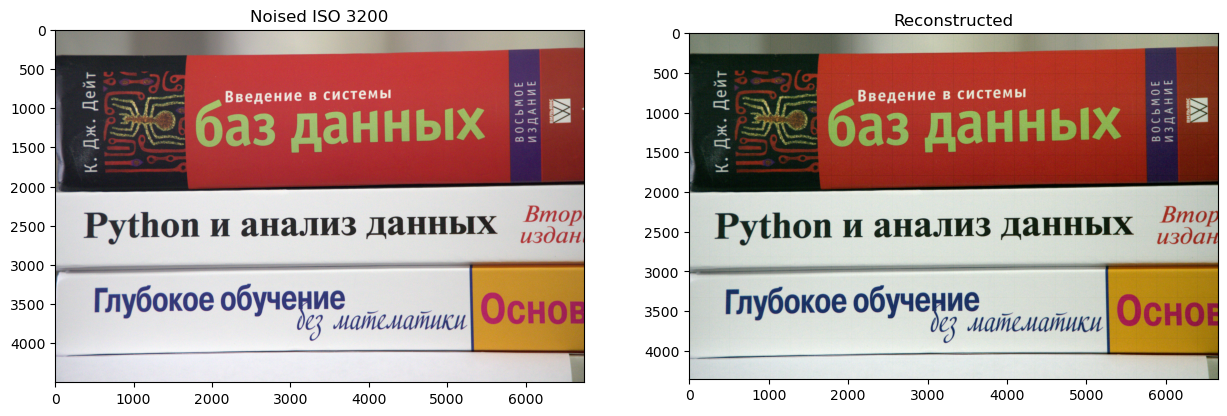

In [17]:
n=8
check_img = images_real[n]

cut_builds = cut_build(source_image=check_img)
images_real_patches = (cut_builds.cut()).astype('float32')
images_real_patches /= 255.
to_model = np.array(images_real_patches)
y_real = model.predict(to_model)
image_real_reconstructed = cut_builds.buid(y_real)

tf.keras.utils.save_img('image_reconstructed_3200.jpg', image_real_reconstructed)

plt.subplots(1,2, figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(check_img)
plt.title('Noised ISO 3200')
plt.subplot(1,2,2)
plt.imshow(image_real_reconstructed)
plt.title('Reconstructed')

14/14 [==============================] - 25s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed')

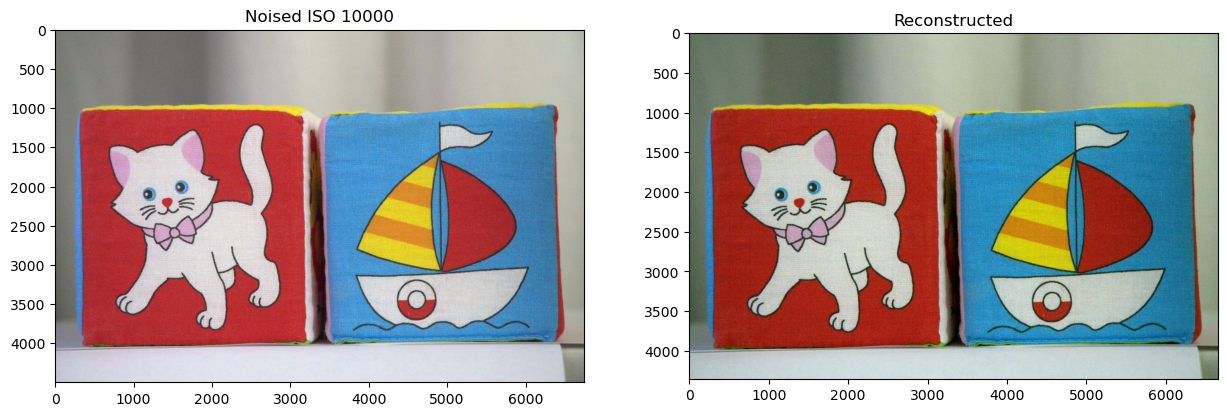

In [19]:
n=2
check_img = images_real[n]

cut_builds = cut_build(source_image=check_img)
images_real_patches = (cut_builds.cut()).astype('float32')
images_real_patches /= 255.
to_model = np.array(images_real_patches)
y_real = model.predict(to_model)
image_real_reconstructed = cut_builds.buid(y_real)

tf.keras.utils.save_img('image_reconstructed_10000.jpg', image_real_reconstructed)

plt.subplots(1,2, figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(check_img)
plt.title('Noised ISO 10000')
plt.subplot(1,2,2)
plt.imshow(image_real_reconstructed)
plt.title('Reconstructed')

9/9 [==============================] - 16s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed')

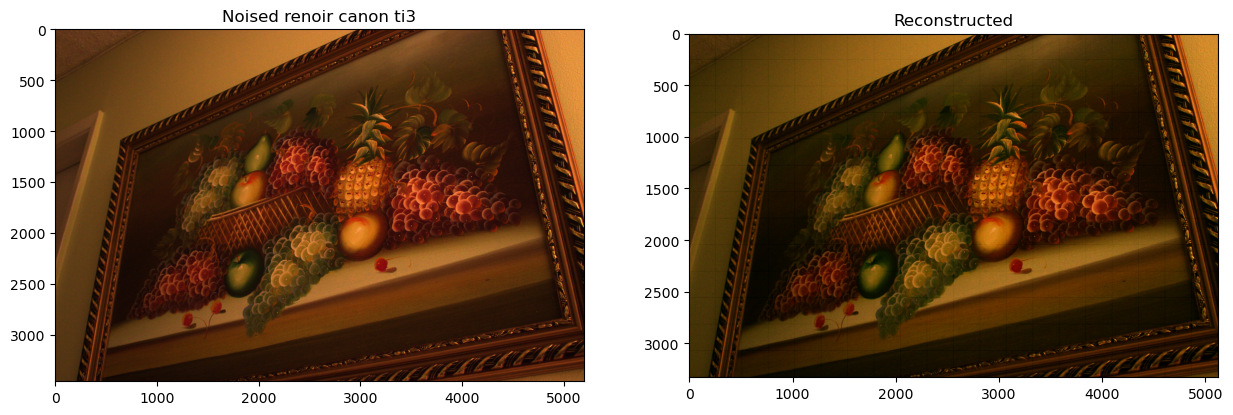

In [22]:
filepath = 'renoir/T3i_Aligned/Batch_016/IMG_7876Noisy.bmp'
check_img = tf.keras.preprocessing.image.load_img(filepath)
check_img = np.array(check_img)

cut_builds = cut_build(source_image=check_img)
images_real_patches = (cut_builds.cut()).astype('float32')
images_real_patches /= 255.
to_model = np.array(images_real_patches)
y_real = model.predict(to_model)
image_real_reconstructed = cut_builds.buid(y_real)

tf.keras.utils.save_img('image_reconstructed_renoir_canon_ti3.jpg', image_real_reconstructed)

plt.subplots(1,2, figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(check_img)
plt.title('Noised renoir canon ti3')
plt.subplot(1,2,2)
plt.imshow(image_real_reconstructed)
plt.title('Reconstructed')

4/4 [==============================] - 6s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed')

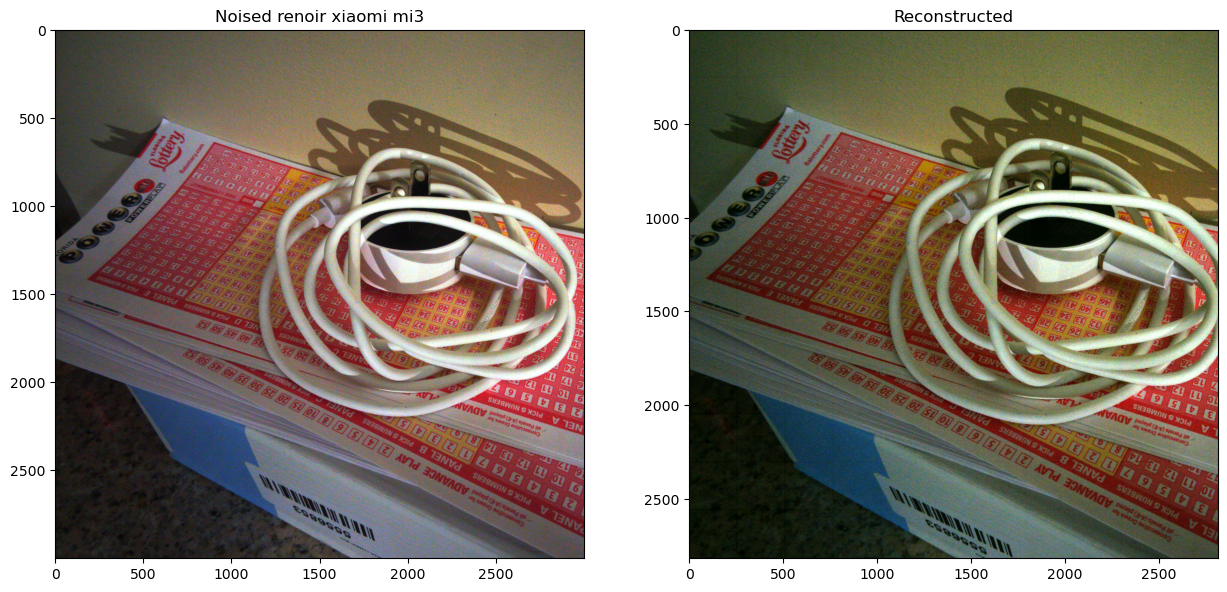

In [25]:
filepath = 'renoir/Mi3_Aligned/Batch_035/IMG_20160222_231102Noisy.bmp'
check_img = tf.keras.preprocessing.image.load_img(filepath)
check_img = np.array(check_img)

cut_builds = cut_build(source_image=check_img)
images_real_patches = (cut_builds.cut()).astype('float32')
images_real_patches /= 255.
to_model = np.array(images_real_patches)
y_real = model.predict(to_model)
image_real_reconstructed = cut_builds.buid(y_real)

tf.keras.utils.save_img('image_reconstructed_renoir_mi3.jpg', image_real_reconstructed)

plt.subplots(1,2, figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(check_img)
plt.title('Noised renoir xiaomi mi3')
plt.subplot(1,2,2)
plt.imshow(image_real_reconstructed)
plt.title('Reconstructed')